# Android Malware Analysis

**Uncomment and run the code below to install all the dependencies used in this Notebook**

In [22]:
# pip install -r ../requirements.txt

In [2]:
import torch
import joblib
import pickle
import sklearn

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Static Analysis

We use a labelled dataset of malicious (type=1) and benign (type=0) Android apps and the smartphone permissions they ask to access. Where an app asks for a specific permission, the value is 1, and 0 otherwise.

In [3]:
df = pd.read_csv("../data/train.csv", sep=";")

In [4]:
df.info() #our entire dataset should be type int64 as it is comprised of binary 0/1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Columns: 331 entries, android to type
dtypes: int64(331)
memory usage: 1.0 MB


In [5]:
df.head()

,android,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,...,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission,type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
df['type'].value_counts()

0    199
1    199
Name: type, dtype: int64

We take a look at the most frequent permissions that both malicious and benign apps ask for to see if there is a pattern.

*Malicious*

In [7]:
mal_ser = pd.Series.sort_values(df[df['type']==1].sum(axis=0), ascending=False)[:10] 
print(mal_ser)

type                                         199
android.permission.INTERNET                  195
android.permission.READ_PHONE_STATE          190
android.permission.ACCESS_NETWORK_STATE      167
android.permission.WRITE_EXTERNAL_STORAGE    136
android.permission.ACCESS_WIFI_STATE         135
android.permission.READ_SMS                  124
android.permission.WRITE_SMS                 104
android.permission.RECEIVE_BOOT_COMPLETED    102
android.permission.ACCESS_COARSE_LOCATION     80
dtype: int64


In [8]:
#we exclude [0] and take 1:11 as 0 corresponds to 'type' which is not a feature
mal_ser = pd.Series.sort_values(df[df['type']==1].sum(axis=0), ascending=False)[1:11] 
print(mal_ser)

android.permission.INTERNET                  195
android.permission.READ_PHONE_STATE          190
android.permission.ACCESS_NETWORK_STATE      167
android.permission.WRITE_EXTERNAL_STORAGE    136
android.permission.ACCESS_WIFI_STATE         135
android.permission.READ_SMS                  124
android.permission.WRITE_SMS                 104
android.permission.RECEIVE_BOOT_COMPLETED    102
android.permission.ACCESS_COARSE_LOCATION     80
android.permission.CHANGE_WIFI_STATE          75
dtype: int64


*Benign*

In [9]:
ben_ser = pd.Series.sort_values(df[df['type']==0].sum(axis=0), ascending=False)[:10]
ben_ser

android.permission.INTERNET                  104
android.permission.WRITE_EXTERNAL_STORAGE     76
android.permission.ACCESS_NETWORK_STATE       62
android.permission.WAKE_LOCK                  36
android.permission.RECEIVE_BOOT_COMPLETED     30
android.permission.ACCESS_WIFI_STATE          29
android.permission.READ_PHONE_STATE           24
android.permission.VIBRATE                    21
android.permission.ACCESS_FINE_LOCATION       18
android.permission.READ_EXTERNAL_STORAGE      15
dtype: int64

In [10]:
permissions = []

for index in mal_ser.index:
    if index not in permissions:
        permissions.append(index)
    
for index in ben_ser.index:
    if index not in permissions:
        permissions.append(index)
        
permissions, len(permissions)

(['android.permission.INTERNET',
  'android.permission.READ_PHONE_STATE',
  'android.permission.ACCESS_NETWORK_STATE',
  'android.permission.WRITE_EXTERNAL_STORAGE',
  'android.permission.ACCESS_WIFI_STATE',
  'android.permission.READ_SMS',
  'android.permission.WRITE_SMS',
  'android.permission.RECEIVE_BOOT_COMPLETED',
  'android.permission.ACCESS_COARSE_LOCATION',
  'android.permission.CHANGE_WIFI_STATE',
  'android.permission.WAKE_LOCK',
  'android.permission.VIBRATE',
  'android.permission.ACCESS_FINE_LOCATION',
  'android.permission.READ_EXTERNAL_STORAGE'],
 14)

The source sorts both charts in descending order of permission frequency for each of the malicious and benign apps, and then sets `sharex=True`. This means that the original mislabels the *Benign Apps* x-axis. 

This is why we created `permissions` list above. We changed this to highlight the difference between access request of malicious and benign apps. We also set titles to make the visualisation more clear.

Text(0.5, 1.0, 'Malicious Apps')

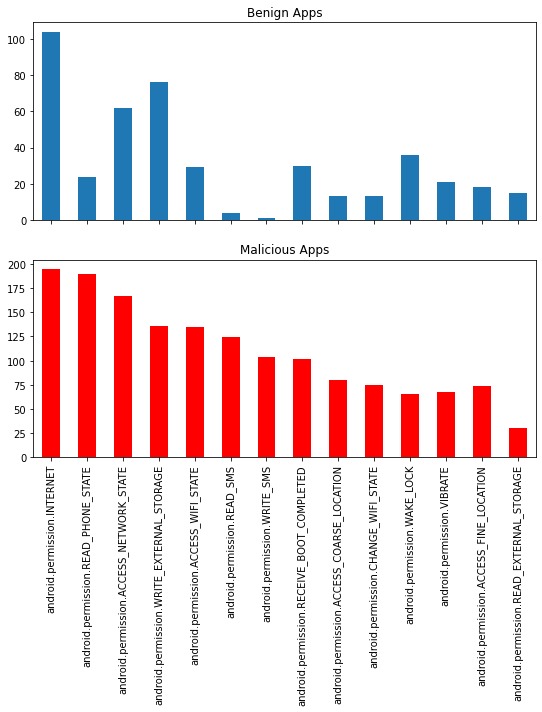

In [11]:
fig, axs =  plt.subplots(nrows=2,sharex=True, figsize=(9,8))

pd.Series.sort_values(df[df.type==0].sum(axis=0), ascending=False)[permissions].plot.bar(ax=axs[0])
axs[0].set_title('Benign Apps')
pd.Series.sort_values(df[df.type==1].sum(axis=0), ascending=False)[permissions].plot.bar(ax=axs[1], color="red")
axs[1].set_title('Malicious Apps')

Alternatively, we plot the 10 most frequent permissions used by the each type of app side by side rather than on top of one another, this time setting `sharey=True`. 

Text(0.5, 1.0, 'Malicious Apps')

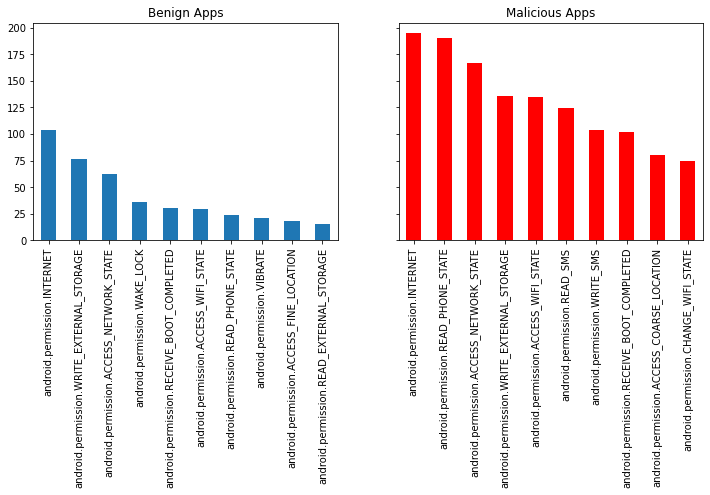

In [12]:
fig, axs =  plt.subplots(ncols=2,sharey=True, figsize=(12,4))

pd.Series.sort_values(df[df.type==0].sum(axis=0), ascending=False)[:10].plot.bar(ax=axs[0])
axs[0].set_title('Benign Apps')
pd.Series.sort_values(df[df.type==1].sum(axis=0), ascending=False)[1:11].plot.bar(ax=axs[1], color="red")
axs[1].set_title('Malicious Apps')

Through the above two visualisations, we can make two observations:
<p></p>
<dl>
    <dd><b>1.</b> Malicious apps prioritise using a different set of permissions, especially Read/Write SMS permissions.</dd>
    <dd><b>2.</b> Malicious apps seem to ask for all permissions more frequently, for example internet access was the most frequently used permission between both type of apps yet 195 malicious apps used this access compared to 104 benign apps.</dd>
</dl>

## Static Analysis Modelling

Here we train and look at the performance of different classifier models on the dataset to predict which apps are malicious and which are benign. We use sklearn's `train_test_split` function to split 67% of the data into a training set and 33% into a test set as opposed to the source's 80:20 split. Our 'output' or 'target' feature `y` will be the `type` column of our dataset.

We look at the accuracy measure of each classifier as well as the `classification report` which includes precision, recall, f1-score, and support. However, as our data is perfectly balanced with 50% malicious and 50% benign apps, we believe that it is sufficient to use accuracy as the main performance metric of each model.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:330], df['type'], test_size=0.33, random_state=42)

#### Naive Bayes

In [14]:
target_names = ['type 0','type 1']

In [15]:
# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# pred
pred = gnb.predict(X_test)

# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(accuracy)
print(classification_report(pred, y_test, labels=None, target_names = target_names))

naive_bayes
0.7651515151515151
              precision    recall  f1-score   support

      type 0       0.90      0.69      0.78        81
      type 1       0.64      0.88      0.74        51

    accuracy                           0.77       132
   macro avg       0.77      0.79      0.76       132
weighted avg       0.80      0.77      0.77       132



The Naive Bayes classifier only gives us an accuracy of 76.5%. <br></br>
(With an 80:20 train:test split the source gets approximately 83.8% accuracy)

#### KNN

In [16]:
# knn algorithm

for i in range(3,13,3): #we run knn for k=3,6,9,12 to see which returns the better result
    
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test,labels=None, target_names = target_names))
    print("")

kneighbors 3
0.8636363636363636
              precision    recall  f1-score   support

      type 0       0.94      0.81      0.87        72
      type 1       0.80      0.93      0.86        60

    accuracy                           0.86       132
   macro avg       0.87      0.87      0.86       132
weighted avg       0.87      0.86      0.86       132


kneighbors 6
0.8712121212121212
              precision    recall  f1-score   support

      type 0       0.95      0.81      0.87        73
      type 1       0.80      0.95      0.87        59

    accuracy                           0.87       132
   macro avg       0.88      0.88      0.87       132
weighted avg       0.88      0.87      0.87       132


kneighbors 9
0.8712121212121212
              precision    recall  f1-score   support

      type 0       0.95      0.81      0.87        73
      type 1       0.80      0.95      0.87        59

    accuracy                           0.87       132
   macro avg       0.88      0

We seem to get the best KNN results when we set k=6,9,12 all of which yield roughly 87.1% accuracy.<br></br>
(With an 80:20 train:test split the source gets the best result for k=3 with approximately 88.8% accuracy)

#### Decision Tree

In [18]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf)
print(accuracy)
print(classification_report(pred, y_test, labels=None, target_names = target_names))

DecisionTreeClassifier()
0.8863636363636364
              precision    recall  f1-score   support

      type 0       0.97      0.82      0.89        73
      type 1       0.81      0.97      0.88        59

    accuracy                           0.89       132
   macro avg       0.89      0.89      0.89       132
weighted avg       0.90      0.89      0.89       132



Here we get the highest accuracy out of our 3 models when using a Decision Tree classifier which yields an accuracy of approximately 89.4%. <br></br>
(With an 80:20 train:test split the source gets 95% accuracy)

Overall, we get the same performance heirarchy as the source between the 3 models when changing our train/test split though we end up achieving lower accuracy with our split selection. This could be due to the comparatively small size (398 rows/obersvations) that we have in this dataset where taking 67% for training is not enough to attain the higher levels of accuracy.


## Dynamic Analysis

For this approach, we used a set of pcap files from the DroidCollector project integrated by 4705 benign and 3141 malicious applications. All of the files were processed by our feature extractor script, the idea of this analysis is to answer the next question, according to the static analysis previously seen a lot of applications use a network connection, in other words, they are trying to communicate or transmit information, so.. is it possible to distinguish between malware and benign application using network traffic?

In [19]:
data = pd.read_csv('../data/android_traffic.csv',sep=';')

In [20]:
data.head()

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,benign
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,NaN,NaN,NaN,7,1,benign
4,AntiVirus,6,0,1,882,0,0,7,6,819,968,NaN,NaN,NaN,7,1,benign


In [134]:
data.columns

Index(['name', 'tcp_packets', 'dist_port_tcp', 'external_ips', 'vulume_bytes',
       'udp_packets', 'tcp_urg_packet', 'source_app_packets',
       'remote_app_packets', 'source_app_bytes', 'remote_app_bytes',
       'duracion', 'avg_local_pkt_rate', 'avg_remote_pkt_rate',
       'source_app_packets.1', 'dns_query_times', 'type'],
      dtype='object')

Here we change some of the column names to clarify what they represent as there were some misspellings and/or mistranslations made by the original source.

In [135]:
data.rename(columns={'name':'app_type','vulume_bytes':'volume_bytes','duracion':'duration'},inplace=True)
data.head()

,app_type,tcp_packets,dist_port_tcp,external_ips,volume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duration,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,benign
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,NaN,NaN,NaN,7,1,benign
4,AntiVirus,6,0,1,882,0,0,7,6,819,968,NaN,NaN,NaN,7,1,benign


In [136]:
data.shape

(7845, 17)

In [137]:
data['type'].value_counts()

benign       4704
malicious    3141
Name: type, dtype: int64

This time we do not have a perfect 50/50 data split and so we may need to look at measures other than just the accuracy of our models going forward.

## Cleaning

As the original author used DroidCollector and then their own scrip to extract/scrape the network traffic for these apps, some of the data needs some cleaning and that is addressed here.

In [138]:
data.isna().sum()

app_type                   0
tcp_packets                0
dist_port_tcp              0
external_ips               0
volume_bytes               0
udp_packets                0
tcp_urg_packet             0
source_app_packets         0
remote_app_packets         0
source_app_bytes           0
remote_app_bytes           0
duration                7845
avg_local_pkt_rate      7845
avg_remote_pkt_rate     7845
source_app_packets.1       0
dns_query_times            0
type                       0
dtype: int64

We have 3 columns where we have absolutely no data and so we can't make use of them. We just drop these columns as they are effectively redundant.

In [139]:
data = data.drop(['duration','avg_local_pkt_rate','avg_remote_pkt_rate'], axis=1).copy()

In [140]:
data.describe()

,tcp_packets,dist_port_tcp,external_ips,volume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,0.000255,152.911918,194.706310,2.024967e+05,1.692260e+04,152.911918,4.898917
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,0.015966,779.034618,1068.112696,1.401076e+06,8.238182e+04,779.034618,18.900478
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,1.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,7.000000,1.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,30.000000,3.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,98.000000,5.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,1.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,37150.000000,913.000000


Here, the original author notes that the tcp_urg_packet column stands out and plots it to explore further. We do the same but we further comment on this and explore some other columns as well.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tcp_urg_packet'>

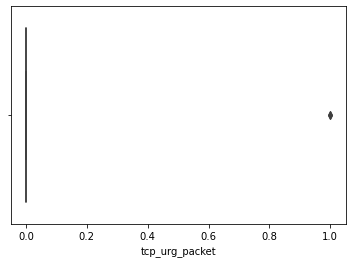

In [141]:
sns.boxplot(data['tcp_urg_packet'])

In [142]:
data.loc[data['tcp_urg_packet'] > 0]

,app_type,tcp_packets,dist_port_tcp,external_ips,volume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
1099,DailyLife,16,16,1,2024,0,1,16,18,2099,2024,16,0,benign
1100,DailyLife,22,22,1,2750,0,1,22,22,2804,2750,22,0,benign


Since only 2 apps have a value of 1 and all other apps have value 0, the original author drops this column and says that is redundant. We agree with this but then decide follow a similar approach to other other columns that seem anomalous and plot boxplots to see if it is reasonable to consider dropping those columns.

In [143]:
data = data.drop('tcp_urg_packet',axis=1).copy()

In [144]:
data.describe()

,tcp_packets,dist_port_tcp,external_ips,volume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,152.911918,194.706310,2.024967e+05,1.692260e+04,152.911918,4.898917
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,779.034618,1068.112696,1.401076e+06,8.238182e+04,779.034618,18.900478
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,1.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,7.000000,1.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,30.000000,3.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,98.000000,5.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,37150.000000,913.000000


We decide that 'dist_port_tcp' and 'udp_packets' seem almost identical in description to tcp_urg_packet so we explore these two.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='udp_packets'>

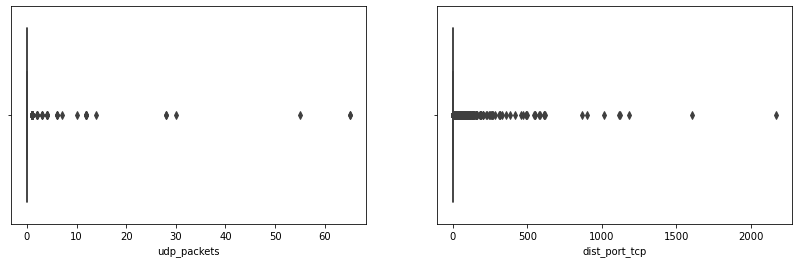

In [145]:
dist_port = data['dist_port_tcp']
udp_pack = data['udp_packets']

fig, axs = plt.subplots(ncols=2,figsize=(14,4))
sns.boxplot(dist_port,ax=axs[1])
sns.boxplot(udp_pack,ax=axs[0])

In [146]:
len(data[udp_pack>0]), len(data[dist_port>0])

(56, 1602)

As seen above, there is far more data that takes non-zero value for the aforementioned columns and so it does not make sense to drop them despite them seeming similar to the 'tcp_urg_packet' column at first glance of the description matrix.

Now we use the `pairplot` function to plot scatterplots between each possible pair of columns and see if we can make any further observations.

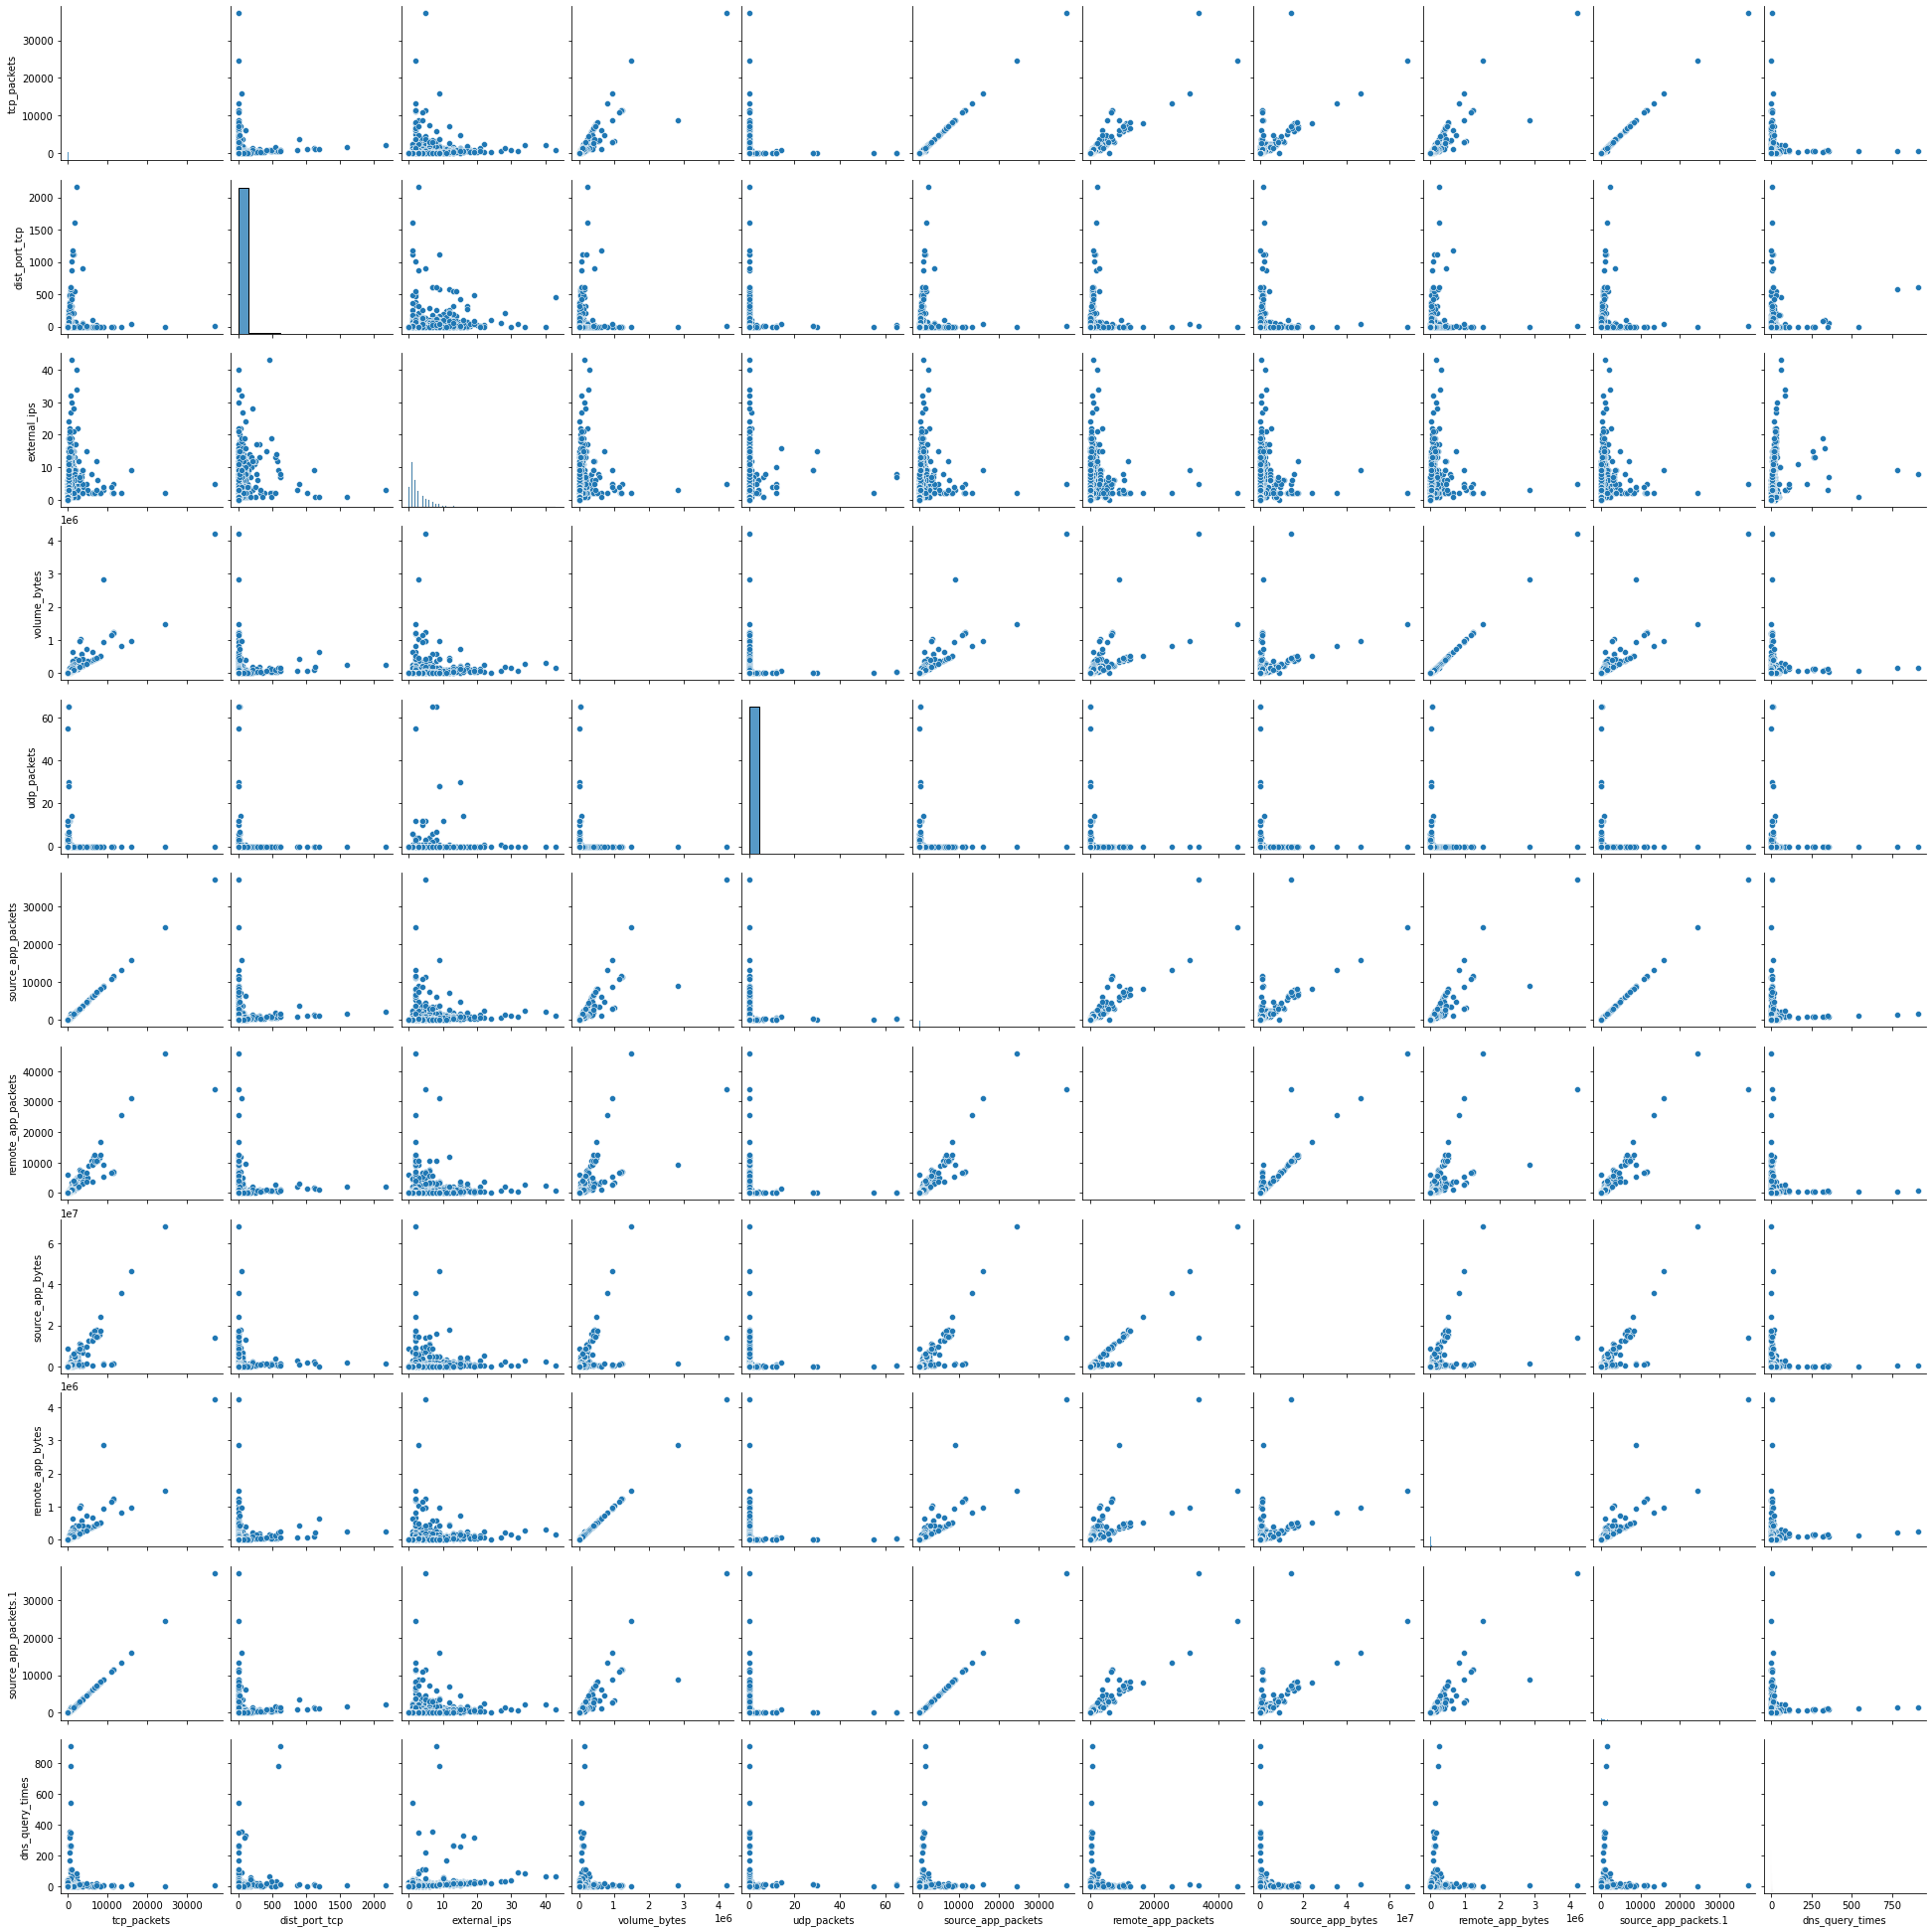

In [147]:
sns.pairplot(data)

In [152]:
# data=data[data.tcp_packets<20000].copy()
# data=data[data.dist_port_tcp<1400].copy()
# data=data[data.external_ips<35].copy()
# data=data[data.volume_bytes<2000000].copy()
# data=data[data.udp_packets<40].copy()
# data=data[data.remote_app_packets<15000].copy()

We comment out the code above used by the author because there was no real clarification behind their reasoning. Instead we explore what happens on the complement of a few of the cases above.

In [148]:
data[data['tcp_packets']>=20000]

,app_type,tcp_packets,dist_port_tcp,external_ips,volume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
1496,Finance,37143,8,5,4226790,0,37150,34036,14124150,4227323,37150,7,benign
3347,Productivity,24513,0,2,1489495,0,24515,45928,68235164,1489645,24515,2,benign


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tcp_packets'>

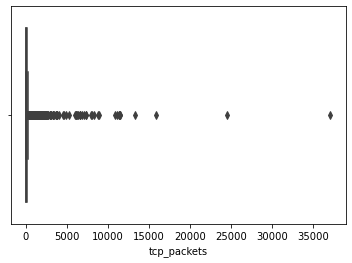

In [154]:
sns.boxplot(data['tcp_packets'])

In [151]:
data[data['dist_port_tcp']>=1400]

,app_type,tcp_packets,dist_port_tcp,external_ips,volume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
1038,DailyLife,2211,2167,3,255335,0,2216,2149,1355156,255720,2216,5,benign
1631,Finance,1603,1603,1,252897,0,1607,1966,1626330,253243,1607,4,benign


In [153]:
data[data['udp_packets']>40]

,app_type,tcp_packets,dist_port_tcp,external_ips,volume_bytes,udp_packets,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
480,chess,0,0,2,8360,55,56,1,300,8430,56,1,benign
2209,MediaAndVideo,115,22,8,37724,65,196,205,164561,38778,196,13,benign
2466,MediaAndVideo,102,0,7,36673,65,174,160,152069,37051,174,5,benign


We can now see that the author was simply dropping the most extreme outliers found within these columns/features. This can be seen in the respective boxplots for each column (the latter two were already plotted above) as well as the short list of 2-3 apps that satisfy these feature paramters.<br></br>
To this effect, we stick with what the author did and find it suitable to drop these apps but we also examine how many rows we are dropping as a result.

In [155]:
len(data)

7845

In [156]:
data=data[data.tcp_packets<20000].copy()
data=data[data.dist_port_tcp<1400].copy()
data=data[data.external_ips<35].copy()
data=data[data.volume_bytes<2000000].copy()
data=data[data.udp_packets<40].copy()
data=data[data.remote_app_packets<15000].copy()

In [158]:
len(data) #we drop 13 rows in total

7832

In [159]:
data[data.duplicated()].sum()

app_type                AntiVirusAntiVirusAntiVirusAntiVirusAntiVirusA...
tcp_packets                                                         15038
dist_port_tcp                                                        3514
external_ips                                                         1434
volume_bytes                                                      2061210
udp_packets                                                            38
source_app_packets                                                  21720
remote_app_packets                                                  18841
source_app_bytes                                                  8615120
remote_app_bytes                                                  2456160
source_app_packets.1                                                21720
dns_query_times                                                      5095
type                    benignbenignbenignbenignbenignbenignbenignbeni...
dtype: object

In [161]:
data[['source_app_packets','source_app_packets.1']]

,source_app_packets,source_app_packets.1
0,39,39
1,128,128
2,205,205
3,7,7
4,7,7
...,...,...
7840,2,2
7841,5,5
7842,2,2
7843,2,2


The two columns are identical and so we drop one.

In [162]:
data=data.drop('source_app_packets.1',axis=1).copy()

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 0 to 7844
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   app_type            7832 non-null   object
 1   tcp_packets         7832 non-null   int64 
 2   dist_port_tcp       7832 non-null   int64 
 3   external_ips        7832 non-null   int64 
 4   volume_bytes        7832 non-null   int64 
 5   udp_packets         7832 non-null   int64 
 6   source_app_packets  7832 non-null   int64 
 7   remote_app_packets  7832 non-null   int64 
 8   source_app_bytes    7832 non-null   int64 
 9   remote_app_bytes    7832 non-null   int64 
 10  dns_query_times     7832 non-null   int64 
 11  type                7832 non-null   object
dtypes: int64(10), object(2)
memory usage: 795.4+ KB


In [167]:
scaler = preprocessing.RobustScaler()
scaledData = scaler.fit_transform(data.iloc[:,1:-1])
scaledData = pd.DataFrame(scaledData, columns=['tcp_packets','dist_port_tcp','external_ips','volume_bytes',
                                               'udp_packets','source_app_packets','remote_app_packets',
                                               'source_app_bytes','remote_app_bytes','dns_query_times'])

## Dynamic Analysis Modelling

In [168]:
X_train, X_test, y_train, y_test = train_test_split(scaledData.iloc[:,0:10], data.type.astype("str"), 
                                                    test_size=0.25, random_state=45)

#### Naive Bayes

In [169]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
## accuracy
accuracy = accuracy_score(y_test,pred)
print("naive_bayes")
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))

naive_bayes
0.44688457609805926
              precision    recall  f1-score   support

      benign       0.81      0.12      0.20      1190
   malicious       0.41      0.96      0.58       768

    accuracy                           0.45      1958
   macro avg       0.61      0.54      0.39      1958
weighted avg       0.66      0.45      0.35      1958

cohen kappa score
0.06082933470572538


#### KNeighbours

In [170]:
# kneighbors algorithm

for i in range(3,15,3):
    
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    print("cohen kappa score")
    print(cohen_kappa_score(y_test, pred))
    print("")

kneighbors 3
0.8861082737487231
              precision    recall  f1-score   support

      benign       0.90      0.91      0.91      1173
   malicious       0.87      0.85      0.86       785

    accuracy                           0.89      1958
   macro avg       0.88      0.88      0.88      1958
weighted avg       0.89      0.89      0.89      1958

cohen kappa score
0.7620541314671169

kneighbors 6
0.8784473953013279
              precision    recall  f1-score   support

      benign       0.92      0.88      0.90      1240
   malicious       0.81      0.87      0.84       718

    accuracy                           0.88      1958
   macro avg       0.87      0.88      0.87      1958
weighted avg       0.88      0.88      0.88      1958

cohen kappa score
0.7420746759356631

kneighbors 9
0.8707865168539326
              precision    recall  f1-score   support

      benign       0.89      0.90      0.89      1175
   malicious       0.85      0.83      0.84       783

    accura

#### Random Forests

In [171]:
rdF=RandomForestClassifier(n_estimators=250, max_depth=50,random_state=45)
rdF.fit(X_train,y_train)
pred=rdF.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)

RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)
0.9172625127681308
              precision    recall  f1-score   support

      benign       0.93      0.94      0.93      1190
   malicious       0.90      0.88      0.89       768

    accuracy                           0.92      1958
   macro avg       0.91      0.91      0.91      1958
weighted avg       0.92      0.92      0.92      1958

cohen kappa score
0.8258206083396299
[[1117   73]
 [  89  679]]
